In [2]:
import io
import json
import os
import sys
import random
import csv
import subprocess
import numpy as np
import pandas as pd
import tifffile as tiff
from PIL import Image
from math import sqrt, exp, log
from matplotlib import cm
from matplotlib import pyplot as plt
from pathlib import Path
from tqdm import tqdm
import re
import shutil
from scipy.ndimage import zoom
from flir_image_extractor import FlirImageExtractor

In [3]:
os.chdir(sys.path[0])

In [10]:
ground_truth = [
    {
        "bread_type": "b",
        "rep": "a",
        # toaster function used to heat up the two slices
        "toaster_energy": 15, "toaster_temperature": 95, "function": '2',
        "time_duration": '0-30',
        "rep_chem": None,
        # probably we should ude the average of acrylamide hence I change this to the average
        "acrylamide_density": 366.1823736,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 29,
        "pictures": ['FLIR0982.jpg', 'FLIR0986.jpg', 'FLIR0990.jpg', 'FLIR0994.jpg', 'FLIR0998.jpg', 'FLIR1002.jpg', 'FLIR1008.jpg', 'FLIR1012.jpg', 'FLIR1020.jpg', 'FLIR1030.jpg']
        # pictures of the same pair of slices, taken at successive moments in time, of which the first is 'FLIR0980.jpg'
    },
    {
        "bread_type": "w",
        "rep": "a",
        "toaster_energy": 15, "toaster_temperature": 95, "function": '2',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": 340.7603585,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 29,
        "pictures": ['FLIR0982.jpg', 'FLIR0986.jpg', 'FLIR0990.jpg', 'FLIR0994.jpg', 'FLIR0998.jpg', 'FLIR1002.jpg', 'FLIR1008.jpg', 'FLIR1012.jpg', 'FLIR1020.jpg', 'FLIR1030.jpg']
    },  # name of file for w and b are the same
    {
        "bread_type": "b",
        "rep": "b",
        "toaster_energy": 10, "toaster_temperature": 95, "function": '2',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": None,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 29.5,
        "pictures": ['FLIR1120.jpg', 'FLIR1122.jpg', 'FLIR1124.jpg', 'FLIR1126.jpg', 'FLIR0998.jpg', 'FLIR1132.jpg', 'FLIR1136.jpg', 'FLIR1140.jpg', 'FLIR1150.jpg', 'FLIR1156.jpg']
    },  # be careful: the picture 'FLIR0998.jpg' is taken from repetition 2a as a replacement for a missing picture at 8min time after toasting
    {
        "bread_type": "w",
        "rep": "b",
        "toaster_energy": 10, "toaster_temperature": 95, "function": '2',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": None,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 29.5,
        # for example ['FLIR1292.jpg', 'FLIR1294.jpg', 'FLIR1296.jpg']
        "pictures": ['FLIR1120.jpg', 'FLIR1122.jpg', 'FLIR1124.jpg', 'FLIR1126.jpg', 'FLIR0998.jpg', 'FLIR1132.jpg', 'FLIR1136.jpg', 'FLIR1140.jpg', 'FLIR1150.jpg', 'FLIR1156.jpg']
        # would mean that the each of the three pictures above contains two slices:
        # this measured white slice and the brown slice in the first dictionary
    },  # be careful: the picture 'FLIR0998.jpg' is taken from repetition 2a as a replacement for a missing picture at 8min time after toasting
    {
        "bread_type": "b",
        "rep": "c",
        "toaster_energy": 15, "toaster_temperature": 95, "function": '2',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": 486.8415406,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 26.3,
        "pictures": ['FLIR1188.jpg', 'FLIR1190.jpg', 'FLIR1192.jpg', 'FLIR1194.jpg', 'FLIR1196.jpg', 'FLIR1198.jpg', 'FLIR1200.jpg', 'FLIR1202.jpg', 'FLIR1208.jpg', 'FLIR1216.jpg']
    },
    {
        "bread_type": "w",
        "rep": "c",
        "toaster_energy": 15, "toaster_temperature": 95, "function": '2',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": 252.1892964,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 26.3,
        "pictures": ['FLIR1188.jpg', 'FLIR1190.jpg', 'FLIR1192.jpg', 'FLIR1194.jpg', 'FLIR1196.jpg', 'FLIR1198.jpg', 'FLIR1200.jpg', 'FLIR1202.jpg', 'FLIR1208.jpg', 'FLIR1216.jpg']
    },
    {
        "bread_type": "b",
        "rep": "d",
        "toaster_energy": 15, "toaster_temperature": 95, "function": '2',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": 419.7128712,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 26.8,
        "pictures": ['FLIR1242.jpg', 'FLIR1246.jpg', 'FLIR1248.jpg', 'FLIR1250.jpg', 'FLIR1254.jpg', 'FLIR1256.jpg', 'FLIR1260.jpg', 'FLIR1264.jpg', 'FLIR1270.jpg', 'FLIR1278.jpg']
    },
    {
        "bread_type": "w",
        "rep": "d",
        "toaster_energy": 15, "toaster_temperature": 95, "function": '2',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": 172.2910249,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 26.8,
        "pictures": ['FLIR1242.jpg', 'FLIR1246.jpg', 'FLIR1248.jpg', 'FLIR1250.jpg', 'FLIR1254.jpg', 'FLIR1256.jpg', 'FLIR1260.jpg', 'FLIR1264.jpg', 'FLIR1270.jpg', 'FLIR1278.jpg']
    },
    {
        "bread_type": "b",
        "rep": "e",
        "toaster_energy": 15, "toaster_temperature": 95, "function": '2',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": 419.0686579,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 27.1,
        "pictures": ['FLIR1352.jpg', 'FLIR1373.jpg', 'FLIR1375.jpg', 'FLIR1377.jpg', 'FLIR1381.jpg', 'FLIR1383.jpg', 'FLIR1389.jpg', 'FLIR1391.jpg', 'FLIR1393.jpg', 'FLIR1399.jpg']
    },  # picture 'FLIR1385.jpg' was removed from list. It was after 'FLIR1383.jpg'
    {
        "bread_type": "w",
        "rep": "e",
        "toaster_energy": 15, "toaster_temperature": 95, "function": '2',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": 285.5174966,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 27.1,
        "pictures": ['FLIR1352.jpg', 'FLIR1373.jpg', 'FLIR1375.jpg', 'FLIR1377.jpg', 'FLIR1381.jpg', 'FLIR1383.jpg', 'FLIR1389.jpg', 'FLIR1391.jpg', 'FLIR1393.jpg', 'FLIR1399.jpg']
    },  # picture 'FLIR1385.jpg' was removed from list. It was after 'FLIR1383.jpg'
    {
        "bread_type": "b",
        "rep": "a",
        "toaster_energy": 22, "toaster_temperature": 151, "function": '4',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": 375.7434793,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 29,
        "pictures": ['FLIR0984.jpg', 'FLIR0988.jpg',  'FLIR0992.jpg', 'FLIR0996.jpg', 'FLIR1000.jpg', 'FLIR1006.jpg', 'FLIR1010.jpg', 'FLIR1014.jpg', 'FLIR1026.jpg', 'FLIR1034.jpg']
    },  # picture 'FLIR1004.jpg' was removed becaus its a duplicate of 'FLIR1006.jpg'. 'FLIR1018.jpg' was removed since duplicate of 'FLIR1014.jpg'
    {
        "bread_type": "w",
        "rep": "a",
        "toaster_energy": 22, "toaster_temperature": 151, "function": '4',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": 357.2200877,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 29,
        "pictures": ['FLIR0984.jpg', 'FLIR0988.jpg',  'FLIR0992.jpg', 'FLIR0996.jpg', 'FLIR1000.jpg', 'FLIR1006.jpg', 'FLIR1010.jpg', 'FLIR1014.jpg', 'FLIR1026.jpg', 'FLIR1034.jpg']
    },  # picture 'FLIR1004.jpg' was removed becaus its a duplicate of 'FLIR1006.jpg'. 'FLIR1018.jpg' was removed since duplicate of 'FLIR1014.jpg'
    {
        "bread_type": "b",
        "rep": "b",
        "toaster_energy": 25, "toaster_temperature": 151, "function": '4',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": 419.732761,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 29,
        "pictures": ['FLIR1064.jpg', 'FLIR1068.jpg', 'FLIR1070.jpg', 'FLIR1072.jpg', 'FLIR1076.jpg', 'FLIR1078.jpg', 'FLIR1088.jpg', 'FLIR1096.jpg', 'FLIR1100.jpg', 'FLIR1108.jpg']
    },
    {
        "bread_type": "w",
        "rep": "b",
        "toaster_energy": 25, "toaster_temperature": 151, "function": '4',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": 299.7274669,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 29,
        "pictures": ['FLIR1064.jpg', 'FLIR1068.jpg', 'FLIR1070.jpg', 'FLIR1072.jpg', 'FLIR1076.jpg', 'FLIR1078.jpg', 'FLIR1088.jpg', 'FLIR1096.jpg', 'FLIR1100.jpg', 'FLIR1108.jpg']
    },
    {
        "bread_type": "b",
        "rep": "c",
        "toaster_energy": 24, "toaster_temperature": 151, "function": '4',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": None,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 26.25,
        "pictures": ['FLIR1204.jpg', 'FLIR1206.jpg', 'FLIR1210.jpg', 'FLIR1212.jpg', 'FLIR1214.jpg', 'FLIR1218.jpg', 'FLIR1220.jpg', 'FLIR1222.jpg', 'FLIR1224.jpg', 'FLIR1226.jpg']
    },
    {
        "bread_type": "w",
        "rep": "c",
        "toaster_energy": 24, "toaster_temperature": 151, "function": '4',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": None,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 26.25,
        "pictures": ['FLIR1204.jpg', 'FLIR1206.jpg', 'FLIR1210.jpg', 'FLIR1212.jpg', 'FLIR1214.jpg', 'FLIR1218.jpg', 'FLIR1220.jpg', 'FLIR1222.jpg', 'FLIR1224.jpg', 'FLIR1226.jpg']
    },
    {
        "bread_type": "b",
        "rep": "d",
        "toaster_energy": 24, "toaster_temperature": 151, "function": '4',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": 432.5928093,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 27,
        "pictures": ['FLIR1262.jpg', 'FLIR1266.jpg', 'FLIR1268.jpg', 'FLIR1272.jpg', 'FLIR1274.jpg', 'FLIR1276.jpg', 'FLIR1280.jpg', 'FLIR1282.jpg', 'FLIR1284.jpg', 'FLIR1286.jpg']
    },
    {
        "bread_type": "w",
        "rep": "d",
        "toaster_energy": 24, "toaster_temperature": 151, "function": '4',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": 373.6000965,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 27,
        "pictures": ['FLIR1262.jpg', 'FLIR1266.jpg', 'FLIR1268.jpg', 'FLIR1272.jpg', 'FLIR1274.jpg', 'FLIR1276.jpg', 'FLIR1280.jpg', 'FLIR1282.jpg', 'FLIR1284.jpg', 'FLIR1286.jpg']
    },
    {
        "bread_type": "b",
        "rep": "e",
        "toaster_energy": 25, "toaster_temperature": 151, "function": '4',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": 500.5409846,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 27.45,
        "pictures": ['FLIR1431.jpg', 'FLIR1433.jpg', 'FLIR1437.jpg', 'FLIR1439.jpg', 'FLIR1441.jpg', 'FLIR1445.jpg', 'FLIR1449.jpg', 'FLIR1451.jpg', 'FLIR1453.jpg', 'FLIR1455.jpg']
    },
    {
        "bread_type": "w",
        "rep": "e",
        "toaster_energy": 25, "toaster_temperature": 151, "function": '4',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": 326.2231323,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 27.45,
        "pictures": ['FLIR1431.jpg', 'FLIR1433.jpg', 'FLIR1437.jpg', 'FLIR1439.jpg', 'FLIR1441.jpg', 'FLIR1445.jpg', 'FLIR1449.jpg', 'FLIR1451.jpg', 'FLIR1453.jpg', 'FLIR1455.jpg']
    },
    {
        "bread_type": "b",
        "rep": "a",
        "toaster_energy": 30, "toaster_temperature": 184, "function": '6',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": 418.8156218,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 29,
        "pictures": ['FLIR1022.jpg', 'FLIR1024.jpg', 'FLIR1028.jpg', 'FLIR1032.jpg', 'FLIR1036.jpg', 'FLIR1038.jpg', 'FLIR1042.jpg', 'FLIR1050.jpg', 'FLIR1056.jpg', 'FLIR1060.jpg'
                     ]  # 'FLIR1016.jpg' was removed since it was taken before toasting. 'FLIR1048.jpg' was removed since duplicate of 'FLIR1050.jpg'
    },
    {
        "bread_type": "w",
        "rep": "a",
        "toaster_energy": 30, "toaster_temperature": 184, "function": '6',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": 309.6694698,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 29,
        "pictures": ['FLIR1022.jpg', 'FLIR1024.jpg', 'FLIR1028.jpg', 'FLIR1032.jpg', 'FLIR1036.jpg', 'FLIR1038.jpg', 'FLIR1042.jpg', 'FLIR1050.jpg', 'FLIR1056.jpg', 'FLIR1060.jpg'
                     ]  # 'FLIR1016.jpg' was removed since it was taken before toasting. 'FLIR1048.jpg' was removed since duplicate of 'FLIR1050.jpg'
    },
    {
        "bread_type": "b",
        "rep": "b",
        "toaster_energy": 30, "toaster_temperature": 184, "function": '6',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": 458.8214942,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 29,
        "pictures": ['FLIR1080.jpg', 'FLIR1084.jpg', 'FLIR1086.jpg', 'FLIR1090.jpg', 'FLIR1092.jpg', 'FLIR1094.jpg', 'FLIR1098.jpg', 'FLIR1106.jpg', 'FLIR1114.jpg', 'FLIR1130.jpg']
    },
    {
        "bread_type": "w",
        "rep": "b",
        "toaster_energy": 30, "toaster_temperature": 184, "function": '6',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": 306.9462959,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 29,
        "pictures": ['FLIR1080.jpg', 'FLIR1084.jpg', 'FLIR1086.jpg', 'FLIR1090.jpg', 'FLIR1092.jpg', 'FLIR1094.jpg', 'FLIR1098.jpg', 'FLIR1106.jpg', 'FLIR1114.jpg', 'FLIR1130.jpg']
    },
    {
        "bread_type": "b",
        "rep": "c",
        "toaster_energy": 30, "toaster_temperature": 184, "function": '6',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": None,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 29.5,
        "pictures": ['FLIR1142.jpg', 'FLIR1146.jpg', 'FLIR1148.jpg', 'FLIR1152.jpg', 'FLIR1154.jpg', 'FLIR1158.jpg', 'FLIR1164.jpg', 'FLIR1170.jpg', 'FLIR1176.jpg', 'FLIR1180.jpg']
    },
    {
        "bread_type": "w",
        "rep": "c",
        "toaster_energy": 30, "toaster_temperature": 184, "function": '6',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": None,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 29.5,
        "pictures": ['FLIR1142.jpg', 'FLIR1146.jpg', 'FLIR1148.jpg', 'FLIR1152.jpg', 'FLIR1154.jpg', 'FLIR1158.jpg', 'FLIR1164.jpg', 'FLIR1170.jpg', 'FLIR1176.jpg', 'FLIR1180.jpg']
    },
    {
        "bread_type": "b",
        "rep": "d",
        "toaster_energy": 29, "toaster_temperature": 184, "function": '6',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": 522.0987849,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 26.8,
        "pictures": ['FLIR1338.jpg', 'FLIR1340.jpg', 'FLIR1342.jpg', 'FLIR1344.jpg', 'FLIR1346.jpg', 'FLIR1348.jpg', 'FLIR1350.jpg', 'FLIR1354.jpg', 'FLIR1379.jpg', 'FLIR1387.jpg']
    },
    {
        "bread_type": "w",
        "rep": "d",
        "toaster_energy": 29, "toaster_temperature": 184, "function": '6',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": 456.5650675,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 26.8,
        "pictures": ['FLIR1338.jpg', 'FLIR1340.jpg', 'FLIR1342.jpg', 'FLIR1344.jpg', 'FLIR1346.jpg', 'FLIR1348.jpg', 'FLIR1350.jpg', 'FLIR1354.jpg', 'FLIR1379.jpg', 'FLIR1387.jpg']
    },
    {
        "bread_type": "b",
        "rep": "e",
        "toaster_energy": 29, "toaster_temperature": 184, "function": '6',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": 540.1094162,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 27.4,
        "pictures": ['FLIR1413.jpg', 'FLIR1415.jpg', 'FLIR1419.jpg', 'FLIR1421.jpg', 'FLIR1425.jpg', 'FLIR1427.jpg', 'FLIR1429.jpg', 'FLIR1435.jpg', 'FLIR1443.jpg', 'FLIR1447.jpg']
    },
    {
        "bread_type": "w",
        "rep": "e",
        "toaster_energy": 29, "toaster_temperature": 184, "function": '6',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": 378.2653163,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 27.4,
        "pictures": ['FLIR1413.jpg', 'FLIR1415.jpg', 'FLIR1419.jpg', 'FLIR1421.jpg', 'FLIR1425.jpg', 'FLIR1427.jpg', 'FLIR1429.jpg', 'FLIR1435.jpg', 'FLIR1443.jpg', 'FLIR1447.jpg']
    },
    {
        "bread_type": "b",
        "rep": "a",
        "toaster_energy": 55, "toaster_temperature": 196, "function": '6x2',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": 1051.213586,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 29,
        "pictures": ['FLIR1040.jpg', 'FLIR1044.jpg', 'FLIR1046.jpg', 'FLIR1052.jpg', 'FLIR1054.jpg', 'FLIR1058.jpg', 'FLIR1062.jpg', 'FLIR1066.jpg', 'FLIR1074.jpg', 'FLIR1082.jpg']
    },
    {
        "bread_type": "w",
        "rep": "a",
        "toaster_energy": 55, "toaster_temperature": 196, "function": '6x2',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": 547.9047929,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 29,
        "pictures": ['FLIR1040.jpg', 'FLIR1044.jpg', 'FLIR1046.jpg', 'FLIR1052.jpg', 'FLIR1054.jpg', 'FLIR1058.jpg', 'FLIR1062.jpg', 'FLIR1066.jpg', 'FLIR1074.jpg', 'FLIR1082.jpg']
    },
    {
        "bread_type": "b",
        "rep": "b",
        "toaster_energy": 55, "toaster_temperature": 196, "function": '6x2',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": 689.6316473,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 29.5,
        "pictures": ['FLIR1102.jpg', 'FLIR1104.jpg', 'FLIR1110.jpg', 'FLIR1112.jpg', 'FLIR1116.jpg', 'FLIR1118.jpg', 'FLIR1128.jpg', 'FLIR1134.jpg', 'FLIR1138.jpg', 'FLIR1144.jpg']
    },
    {
        "bread_type": "w",
        "rep": "b",
        "toaster_energy": 55, "toaster_temperature": 196, "function": '6x2',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": 496.6898001,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 29.5,
        "pictures": ['FLIR1102.jpg', 'FLIR1104.jpg', 'FLIR1110.jpg', 'FLIR1112.jpg', 'FLIR1116.jpg', 'FLIR1118.jpg', 'FLIR1128.jpg', 'FLIR1134.jpg', 'FLIR1138.jpg', 'FLIR1144.jpg']
    },
    {
        "bread_type": "b",
        "rep": "c",
        "toaster_energy": 55, "toaster_temperature": 196, "function": '6x2',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": 764.1425296,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 28.5,
        "pictures": ['FLIR1160.jpg', 'FLIR1162.jpg', 'FLIR1166.jpg', 'FLIR1168.jpg', 'FLIR1172.jpg', 'FLIR1174.jpg', 'FLIR1178.jpg', 'FLIR1182.jpg', 'FLIR1184.jpg', 'FLIR1186.jpg']
    },
    {
        "bread_type": "w",
        "rep": "c",
        "toaster_energy": 55, "toaster_temperature": 196, "function": '6x2',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": 616.215857,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 28.5,
        "pictures": ['FLIR1160.jpg', 'FLIR1162.jpg', 'FLIR1166.jpg', 'FLIR1168.jpg', 'FLIR1172.jpg', 'FLIR1174.jpg', 'FLIR1178.jpg', 'FLIR1182.jpg', 'FLIR1184.jpg', 'FLIR1186.jpg']
    },
    {
        "bread_type": "b",
        "rep": "d",
        "toaster_energy": 53, "toaster_temperature": 196, "function": '6x2',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": 727.8157318,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 26.55,
        "pictures": ['FLIR1228.jpg', 'FLIR1230.jpg', 'FLIR1232.jpg', 'FLIR1234.jpg', 'FLIR1236.jpg', 'FLIR1238.jpg', 'FLIR1240.jpg', 'FLIR1244.jpg', 'FLIR1252.jpg', 'FLIR1258.jpg']
    },
    {
        "bread_type": "w",
        "rep": "d",
        "toaster_energy": 53, "toaster_temperature": 196, "function": '6x2',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": 324.8391756,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 26.55,
        "pictures": ['FLIR1228.jpg', 'FLIR1230.jpg', 'FLIR1232.jpg', 'FLIR1234.jpg', 'FLIR1236.jpg', 'FLIR1238.jpg', 'FLIR1240.jpg', 'FLIR1244.jpg', 'FLIR1252.jpg', 'FLIR1258.jpg']
    },
    {
        "bread_type": "b",
        "rep": "e",
        "toaster_energy": 54, "toaster_temperature": 196, "function": '6x2',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": None,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 27.25,
        "pictures": ['FLIR1395.jpg', 'FLIR1397.jpg', 'FLIR1401.jpg', 'FLIR1403.jpg', 'FLIR1405.jpg', 'FLIR1407.jpg', 'FLIR1409.jpg', 'FLIR1411.jpg', 'FLIR1417.jpg', 'FLIR1423.jpg'
                     ]
    },
    {
        "bread_type": "w",
        "rep": "e",
        "toaster_energy": 54, "toaster_temperature": 196, "function": '6x2',
        "time_duration": '0-30',
        "rep_chem": None,
        "acrylamide_density": None,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": 27.25,
        "pictures": ['FLIR1395.jpg', 'FLIR1397.jpg', 'FLIR1401.jpg', 'FLIR1403.jpg', 'FLIR1405.jpg', 'FLIR1407.jpg', 'FLIR1409.jpg', 'FLIR1411.jpg', 'FLIR1417.jpg', 'FLIR1423.jpg'
                     ]
    }
]

In [19]:
def resize(thermal_channel, metadata):
    Real2IR = metadata['Real2IR']
    OffsetX = metadata['OffsetX']
    OffsetY = metadata['OffsetY']
    W_dest = metadata['EmbeddedImageWidth']
    H_dest = metadata['EmbeddedImageHeight']

    # Define grid for interpolation
    # order=1 corresponds to linear interpolation
    H_orig, W_orig = thermal_channel.shape
    # metadata["PiPX2"] == W_orig
    # metadata["PiPY2"] == H_orig
    # quando zoommo il canale termico non voglio farlo scalare da (60, 80) a (480, 640)
    # devo zoommare il canale termino ad una misura (R, C) tale che (60, 80) < (R, C) <  (480, 640)
    # note that (W_dest/W_orig) == (H_dest/H_orig)
    scale_factor = (1.0/Real2IR)*(H_dest/H_orig)
    thermal_channel_scaled = zoom(thermal_channel, zoom=(
        scale_factor, scale_factor), order=1)
    H_scaled, W_scaled = thermal_channel_scaled.shape
    thermal_channel_new_with_nan = np.full(
        (H_dest, W_dest), np.nan, dtype=np.float64)

    rgb_cx = int(W_dest/2)
    rgb_cy = int(H_dest/2)
    t_cx = int(rgb_cx + OffsetX*Real2IR)
    t_cy = int(rgb_cy + OffsetY*Real2IR)
    # TODO: modify the content of thermal_channel_new_with_nan to place
    #       thermal_channel_scaled inside thermal_channel_new_with_nan so that the center of
    #       thermal_channel_scaled corresponds to the
    # Place the rescaled thermal image into the new array at the correct location
    # before 19 sept this operation was int((W_dest-W_scaled)/2) + OffsetX
    start_x = int(t_cx - W_scaled/2)
    end_x = start_x + W_scaled
    # before 19 sept this operation was int((W_dest-W_scaled)/2) + OffsetY
    start_y = int(t_cy - H_scaled/2)
    end_y = start_y + H_scaled
    thermal_channel_new_with_nan[start_y:end_y,
                                 start_x:end_x] = thermal_channel_scaled

    return thermal_channel_new_with_nan


def create_illustration(rgb_filename, rgb_matrix, mask_matrix, t_matrix_with_nan):
    t_matrix_with_nan_masked = np.where(mask_matrix == 0, np.nan, t_matrix_with_nan)
    min_temp = np.nanmin(t_matrix_with_nan_masked)
    max_temp = np.nanmax(t_matrix_with_nan_masked)
    delta_temp = abs(max_temp-min_temp)
    t_matrix_with_nan_masked_norm = (t_matrix_with_nan_masked.astype(np.float32) - min_temp)/delta_temp
    cmap = plt.colormaps.get_cmap('rainbow')  # or 'nipy_spectral'
    thermal_channel_as_rgb = cmap(t_matrix_with_nan_masked_norm)[:, :, :3] #this is normalized
    plt.imshow(thermal_channel_as_rgb)
    plt.title(f'{Path(rgb_filename).stem}')
    plt.show()
    rgb_matrix_norm = (rgb_matrix.astype(np.float32))/255.0
    rgb_matrix_norm_masked = np.dstack(
        (rgb_matrix_norm, mask_matrix))  # Shape is (H, W, 4)
    plt.imshow(rgb_matrix_norm_masked)
    plt.title(f'{Path(rgb_filename).stem}')
    plt.show()
    alpha = 0.35
    thermally_enhanced_rgb = (1-alpha)*rgb_matrix_norm + \
        alpha * thermal_channel_as_rgb
    plt.imshow(thermally_enhanced_rgb)
    plt.title(f'{Path(rgb_filename).stem}')
    plt.show()
    return thermally_enhanced_rgb

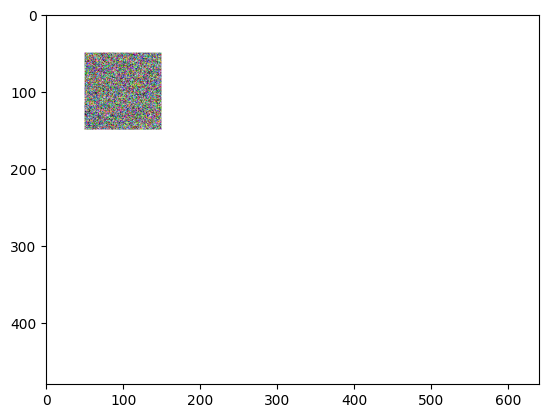

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Create a sample image (RGB) of shape (10, 10, 3)
H, W = 480, 640
M = np.random.rand(H, W, 4)
M[:, :, 3] = 0

# Set a pixel to NaN (make it NaN for all channels)
M[50:150, 50:150, 3] = 1

# Plot the image
plt.imshow(M)
plt.show()

In [17]:
rgbt_jpg_source_dir = os.path.join(
    'raw_data_source', 'RGBT_jpg')
t_npy_dest_dir = os.path.join(
    'raw_data_source', 'T_npy')
rgb_npy_dest_dir = os.path.join(
    'raw_data_source', 'RGB_npy')

rgbt_jpg_file_list = sorted([os.path.join(
    rgbt_jpg_source_dir, n) for n in os.listdir(rgbt_jpg_source_dir) if not n.startswith('.') and n.endswith('.jpg')])
rgb_npy_file_list = sorted([os.path.join(
    rgb_npy_dest_dir, n) for n in os.listdir(rgb_npy_dest_dir) if not n.startswith('.') and n.endswith('.npy')])
t_npy_file_list = sorted([os.path.join(
    t_npy_dest_dir, n) for n in os.listdir(t_npy_dest_dir) if not n.startswith('.') and n.endswith('.npy')])

print(f'len(rgbt_jpg_file_list) == {len(rgbt_jpg_file_list)}')
print(f'len(rgb_npy_file_list) == {len(rgb_npy_file_list)}')
print(f'len(t_npy_file_list) == {len(t_npy_file_list)}')

len(rgbt_jpg_file_list) == 205
len(rgb_npy_file_list) == 205
len(t_npy_file_list) == 205


**CREATION OF TWO DATAFRAMES WITH AVERAGE VALUES OF PIXELS IDENTIFIED BY THE MASKS**

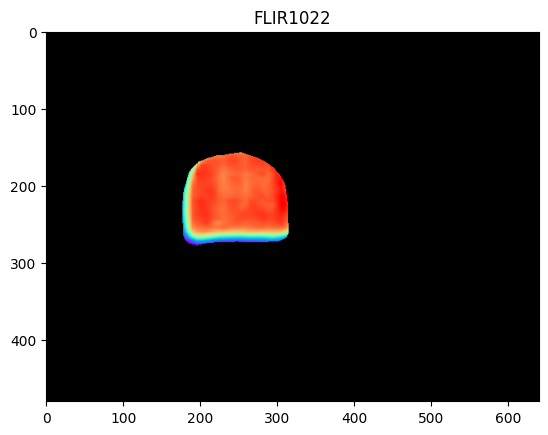

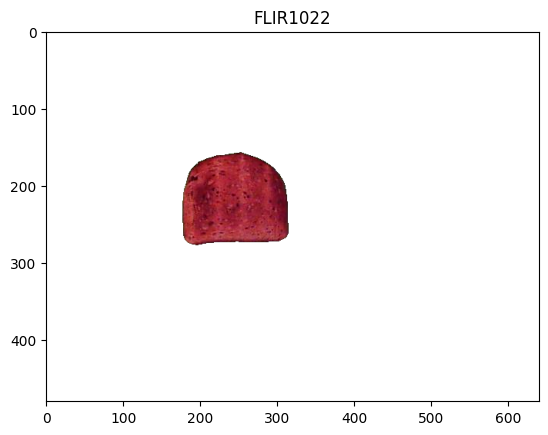

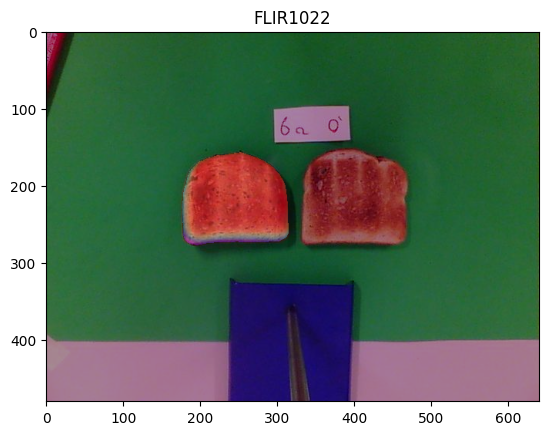

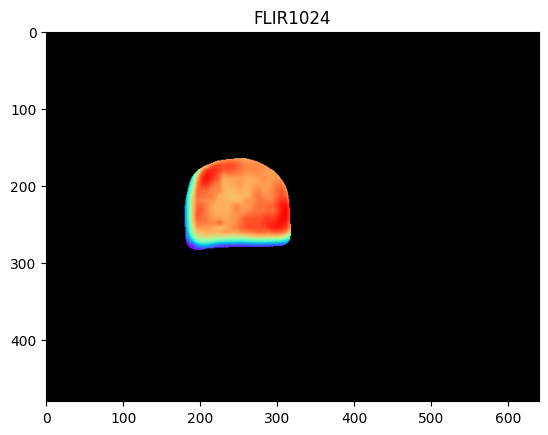

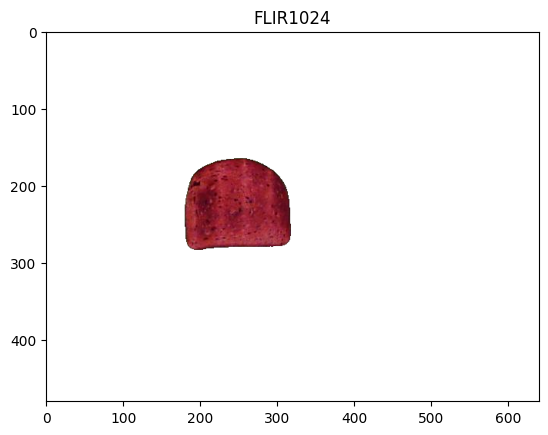

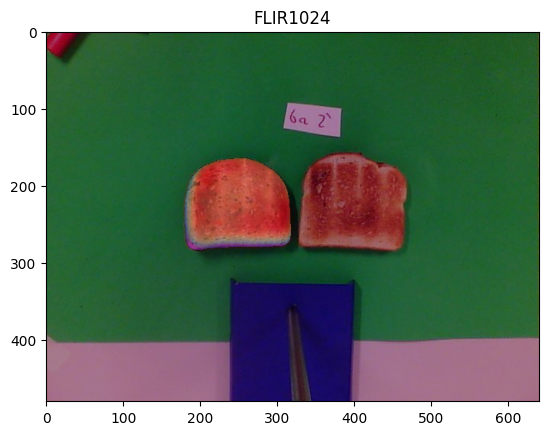

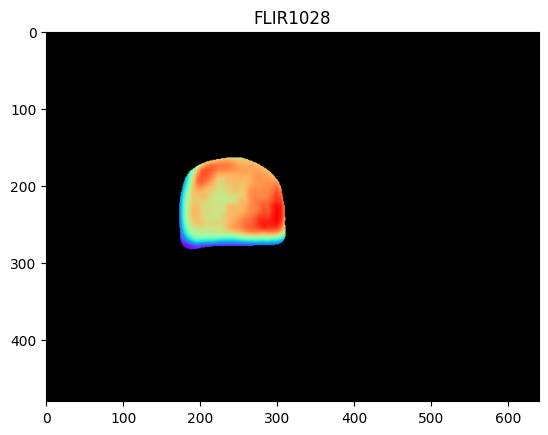

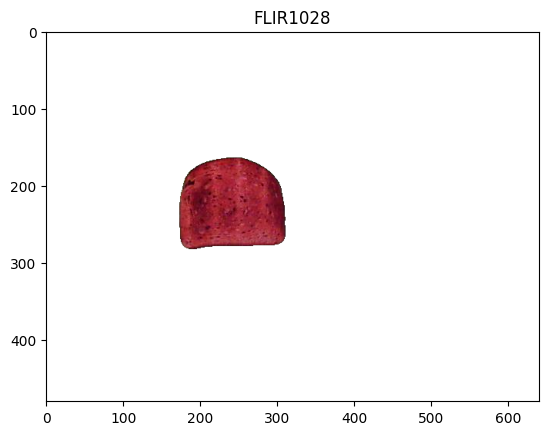

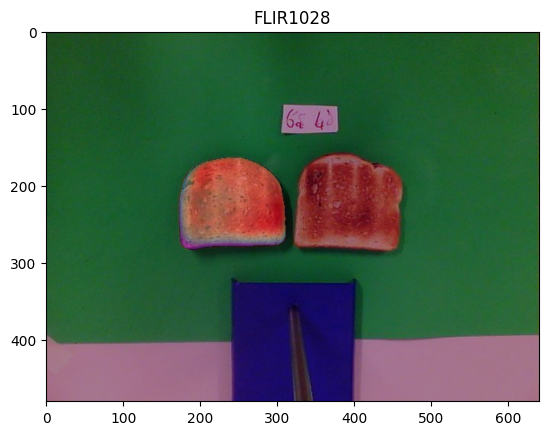

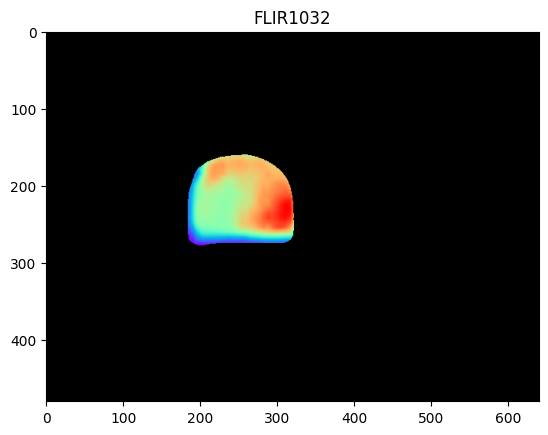

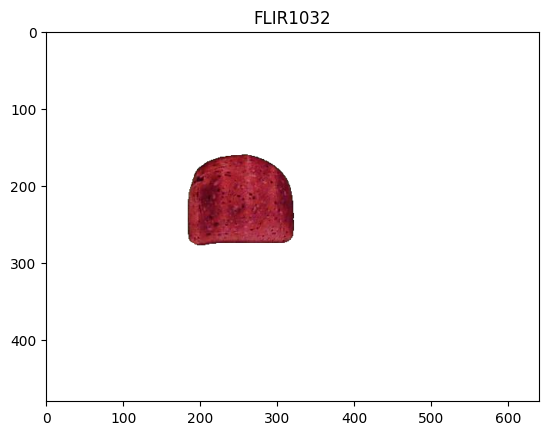

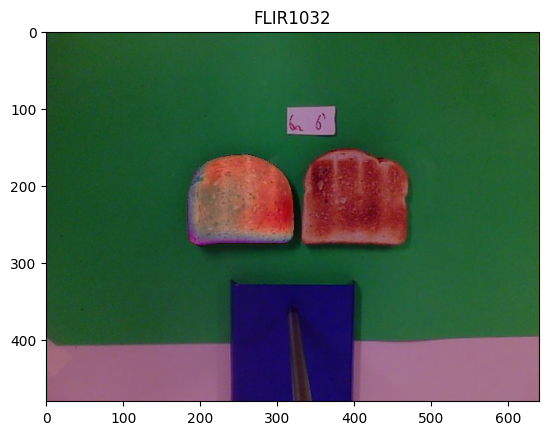

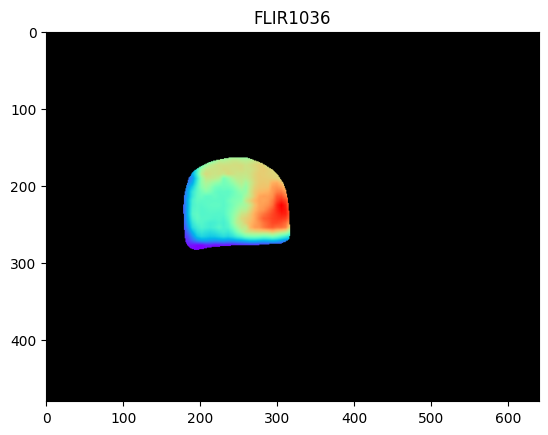

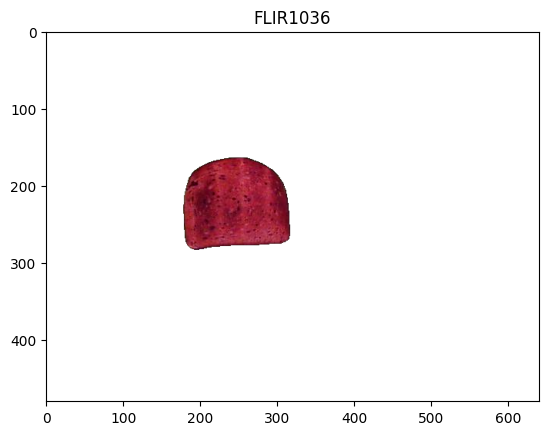

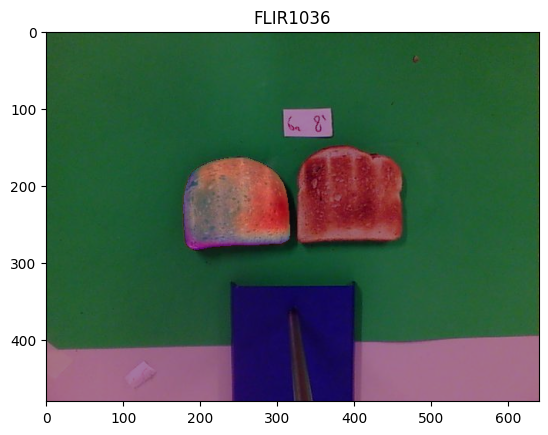

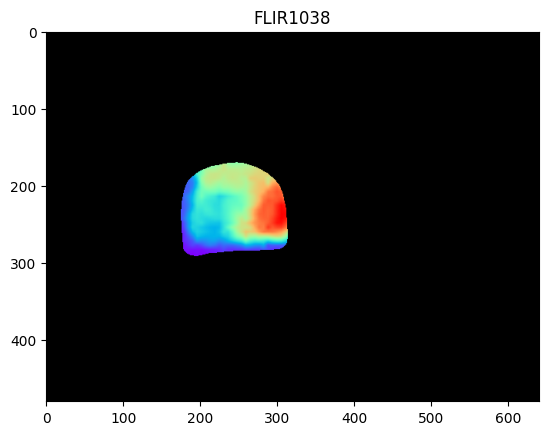

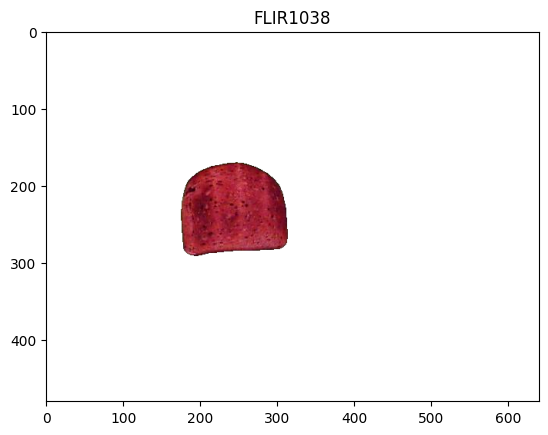

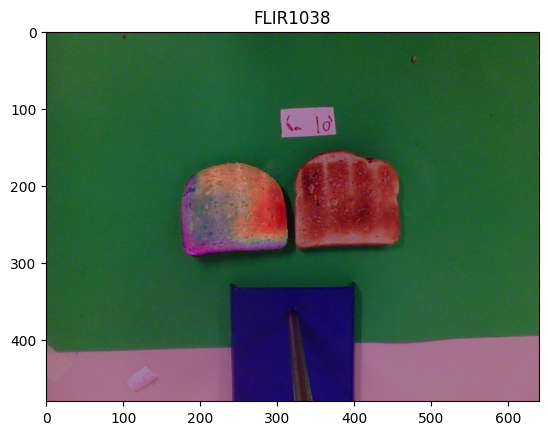

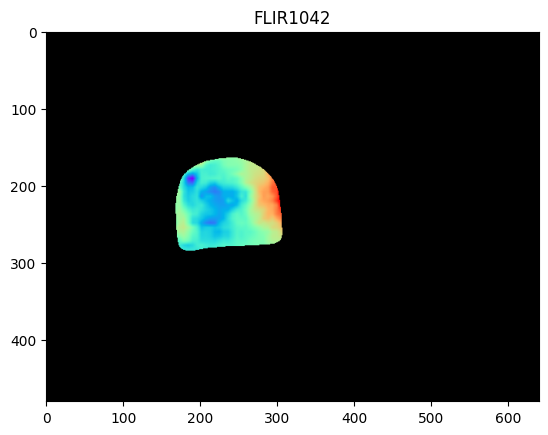

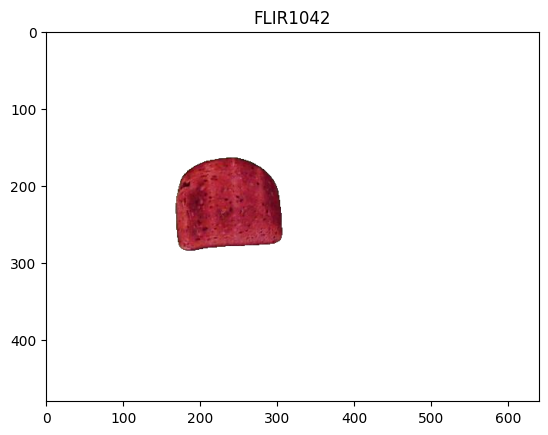

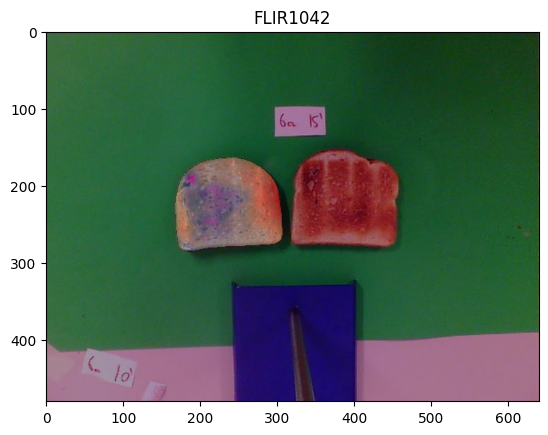

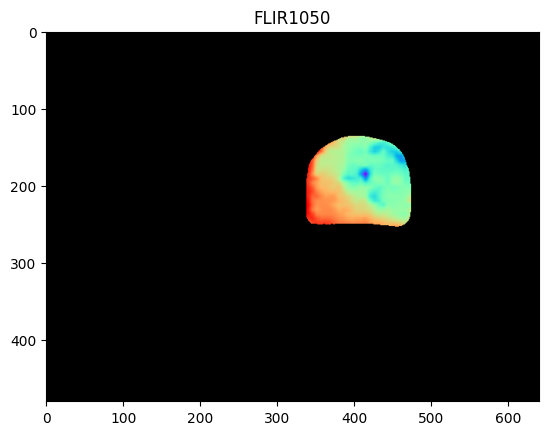

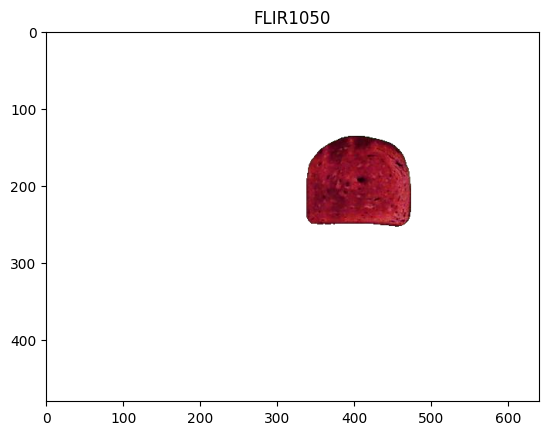

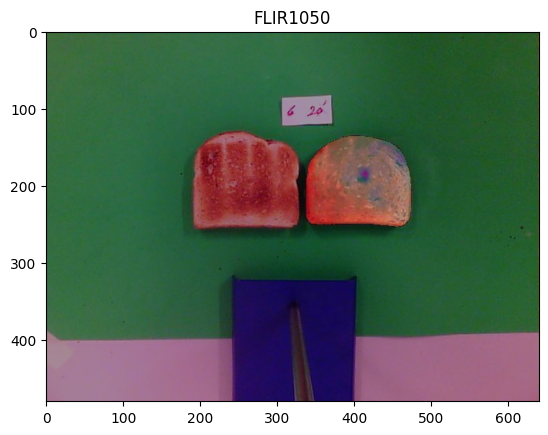

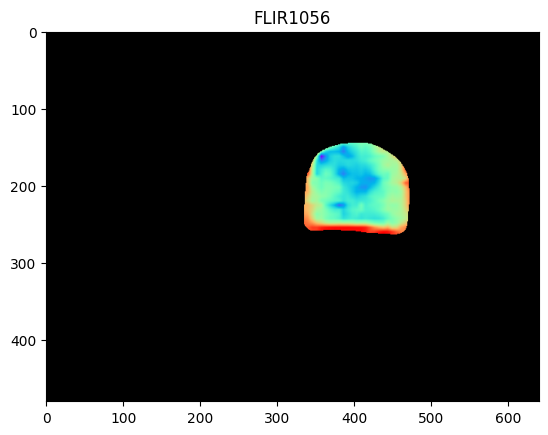

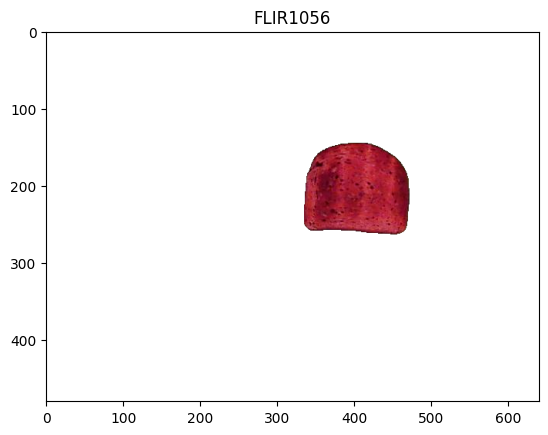

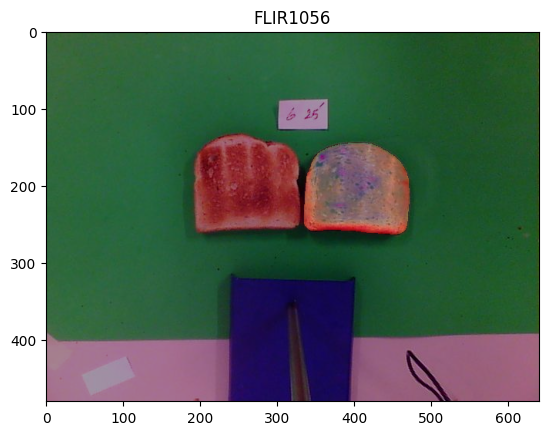

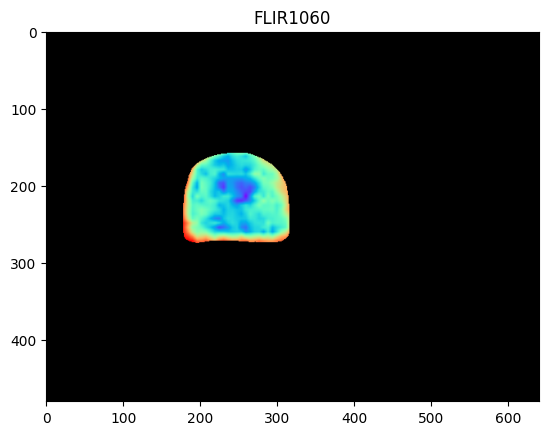

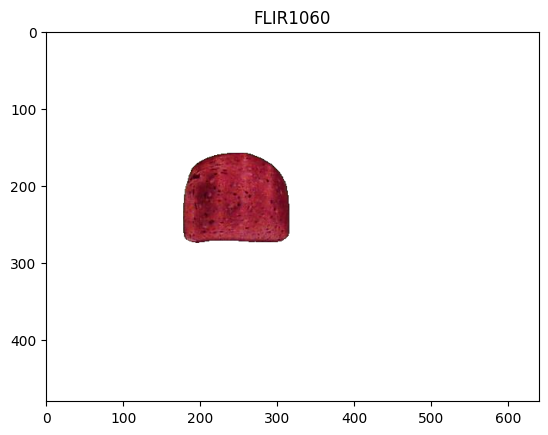

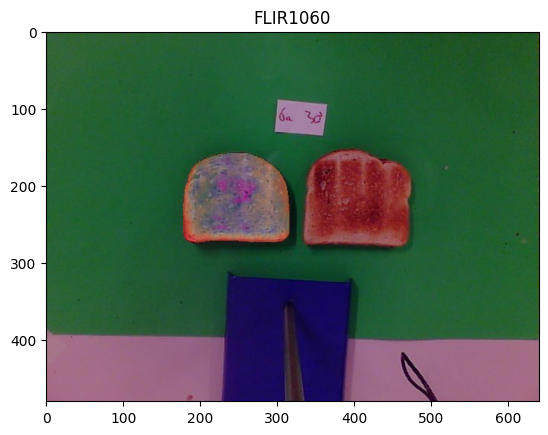

In [20]:
dataframe_white_bread = []
dataframe_brown_bread = []

fie = FlirImageExtractor(exiftool_path='exiftool')

default_metadata = {
    "Real2IR": 1.4022262096405,
    "OffsetX": 0,
    "OffsetY": -12,
    "PiPX1": 0,
    "PiPX2": 80,
    "PiPY1": 0,
    "PiPY2": 60,
    "EmbeddedImageWidth": 640,
    "EmbeddedImageHeight": 480
}

for j, old_record in enumerate(ground_truth):

    new_record = {}
    new_record['acrylamide_density'] = old_record['acrylamide_density']
    new_record['toaster_energy'] = old_record['toaster_energy']
    new_record['toaster_temperature'] = old_record['toaster_temperature']
    new_record['room_temperature'] = old_record['room_temperature']

    for i, rgb_filename in enumerate(old_record['pictures']):
        rgb_matrix = np.load(os.path.join('raw_data_source', 'RGB_npy', f'{Path(rgb_filename).stem}.npy'))
        t_filename = os.path.join('raw_data_source', 'T_npy', f'{Path(rgb_filename).stem}.npy')
        t_matrix = np.load(t_filename)
        t_matrix_with_nan = resize(t_matrix, default_metadata)

        if old_record['bread_type'] == 'b':
            mask_filename = os.path.join('raw_data_source', 'brown_slice_masks', f'{Path(rgb_filename).stem}.tiff')
        elif old_record['bread_type'] == 'w':
            mask_filename = os.path.join('raw_data_source', 'white_slice_masks', f'{Path(rgb_filename).stem}.tiff')
 
        mask_matrix = tiff.imread(mask_filename)
        ####
        selected_pixel_values = (rgb_matrix[:, :, 0])[mask_matrix == 1]
        new_record[f'mean_red_{i}'] = np.mean(selected_pixel_values)
        new_record[f'stdev_red_{i}'] = np.std(selected_pixel_values)
        ####
        selected_pixel_values = (rgb_matrix[:, :, 1])[mask_matrix == 1]
        new_record[f'mean_green_{i}'] = np.mean(selected_pixel_values)
        new_record[f'stdev_green_{i}'] = np.std(selected_pixel_values)
        ####
        selected_pixel_values = (rgb_matrix[:, :, 2])[mask_matrix == 1]
        new_record[f'mean_blue_{i}'] = np.mean(selected_pixel_values)
        new_record[f'stdev_blue_{i}'] = np.std(selected_pixel_values)
        ####
        selected_pixel_values = t_matrix_with_nan[mask_matrix == 1]
        new_record[f'mean_t_{i}'] = np.nanmean(selected_pixel_values)
        new_record[f'stdev_t_{i}'] = np.nanstd(selected_pixel_values)

        if j == 20:
            create_illustration(rgb_filename, rgb_matrix, mask_matrix, t_matrix_with_nan)

    if old_record['bread_type'] == 'b':
        dataframe_brown_bread.append(new_record)
    elif old_record['bread_type'] == 'w':
        dataframe_white_bread.append(new_record)
    else:
        print(f'Wrong bread type.')

dest_csv = 'dataframe_white_bread.csv'
if not (os.path.exists(dest_csv) and os.path.isfile(dest_csv)):
    df_white = pd.DataFrame(dataframe_white_bread)
    df_white.to_csv(dest_csv, index=False)
    print(f"Dataframe saved to file {dest_csv}")

dest_csv = 'dataframe_brown_bread.csv'
if not (os.path.exists(dest_csv) and os.path.isfile(dest_csv)):
    df_brown = pd.DataFrame(dataframe_brown_bread)
    df_brown.to_csv(dest_csv, index=False)
    print(f"Dataframe saved to file {dest_csv}")

**PERFORM SOME CHECKS ON THE DATAFRAMES**

In [ ]:
source_csv = 'dataframe_white_bread.csv'
df = pd.read_csv(source_csv)
###
# exclude the colour information of the first picture (taken before toasting?)
columns = [f'avg_red_{i}' for i in range(0, 10)]
# Compute the row-wise mean and standard deviation
df['avg_red_0-9'] = df[columns].mean(axis=1)
df['std_dev_avg_red_0-9'] = df[columns].std(axis=1)
###
# exclude the colour information of the first picture (taken before toasting?)
columns = [f'avg_green_{i}' for i in range(0, 10)]
# Compute the row-wise mean and standard deviation
df['avg_green_0-9'] = df[columns].mean(axis=1)
df['std_dev_avg_green_0-9'] = df[columns].std(axis=1)
###
columns = [f'avg_blue_{i}' for i in range(0, 10)]#exclude the colour information of the first picture (taken before toasting?)
# Compute the row-wise mean and standard deviation
df['avg_blue_0-9'] = df[columns].mean(axis=1)
df['std_dev_avg_blue_0-9'] = df[columns].std(axis=1)
###
summary_columns = ['avg_red_0-9', 'std_dev_avg_red_0-9',
                   'avg_green_0-9', 'std_dev_avg_green_0-9',
                   'avg_blue_0-9', 'std_dev_avg_blue_0-9']
# View the updated dataframe with the computed mean and std_dev
print(df[summary_columns])
df.to_csv('dataframe_white_bread.csv', index=False)

In [23]:
#bread_type = 'brown_bread'
bread_type = 'white_bread'
source_csv = f'dataframe_{bread_type}.csv'

df = pd.read_csv(source_csv)
###
columns_to_keep = ['acrylamide_density', 'toaster_energy', 'toaster_temperature', 'room_temperature',
                    'mean_red_9', 'stdev_red_9', 'mean_green_9', 'stdev_green_9', 'mean_blue_9', 'stdev_blue_9'] +\
                [f'mean_t_{i}' for i in range(10)] +\
                [f'stdev_t_{i}' for i in range(10)]
df = df[columns_to_keep]
# Find the maximum value across all rows and columns in temp_columns
temperature_columns = [f'mean_t_{j}' for j in range(10)] +\
                    [f'stdev_t_{i}' for i in range(10)] +\
                    ['toaster_temperature', 'room_temperature']
max_temperature = df[temperature_columns].max().max()
### TRY WITH KELVIN INSTEAD OF CELSIUS
# Transform each value x in the column as x/max_acrylamide_density
df[temperature_columns] = df[temperature_columns] / max_temperature
df['acrylamide_density'] = df['acrylamide_density'] / df['acrylamide_density'].max()
df['toaster_energy'] = df['toaster_energy'] / df['toaster_energy'].max()
df['mean_red_9'] = df['mean_red_9'] / 255.0
df['stdev_red_9'] = df['stdev_red_9'] / 255.0
df['mean_green_9'] = df['mean_green_9'] / 255.0
df['stdev_green_9'] = df['stdev_green_9'] / 255.0
df['mean_blue_9'] = df['mean_blue_9'] / 255.0
df['stdev_blue_9'] = df['stdev_blue_9'] / 255.0
###
dest_csv = f'dataframe_{bread_type}_normalized.csv'
df.to_csv(dest_csv, index=False)

**CODE USED TO PRODCE THE .npy FILES FROM ORIGINAL RGBT IMAGES**

In [ ]:
fie = FlirImageExtractor(exiftool_path='exiftool')

raw_dataset = [] 

for rgbt_file in tqdm(rgbt_jpg_file_list):
    meta = None

    try:
        fie.process_image(rgbt_file)
    except Exception as e:
        print(f"An error occurred calling fie.process_image(): {e}")
    
    try:
        meta = fie.get_metadata()
    except Exception as e:
        print(f"An error occurred calling fie.get_metadata(): {e}")
    
    try:
        thermal_channel = fie.get_thermal_np()
        min_temp = np.min(thermal_channel)
        max_temp = np.max(thermal_channel)
        delta_temp = abs(max_temp-min_temp)
        thermal_channel_norm = (thermal_channel.astype(np.float32) - min_temp)/delta_temp
        cmap = plt.colormaps.get_cmap('rainbow')  # or 'nipy_spectral'
        thermal_channel_as_rgb = cmap(thermal_channel_norm)[:, :, :3]
        dest_npy_file = os.path.join(t_npy_dest_dir, f'{Path(rgbt_file).stem}.npy')
        plt.imshow(thermal_channel_as_rgb)
        plt.title(f'{Path(dest_npy_file).stem}')
        plt.show()
        #np.save(dest_npy_file, thermal_channel)
        meta["t_numpy_file"] = dest_npy_file
    except Exception as e:
        print(f"An error occurred calling fie.get_thermal_np(): {e}")
        meta["t_numpy_file"] = None
    
    try:
        rgb_channels = fie.get_rgb_np()
        dest_npy_file = os.path.join(rgb_npy_dest_dir, f'{Path(rgbt_file).stem}.npy')
        # np.save(dest_npy_file, rgb_channels)
        meta["rgb_numpy_file"] = dest_npy_file
    except Exception as e:
        print(f"An error occurred calling fie.get_rgb_np(): {e}")
        meta["rgb_numpy_file"] = None

    if meta is not None:
        # json_string = json.dumps(meta, indent=4).replace('null', 'None')
        raw_dataset.append(meta)

# df = pd.DataFrame(raw_dataset)

# Save the DataFrame to a CSV file
# df.to_csv('raw_data_source.csv', index=False)

In [ ]:
brown_stacked_masked_channels_dir = os.path.join(
    'raw_data_source', 'brown_stacked_masked_channels')
brown_stacked_masked_channels_file_list = sorted([os.path.join(
    brown_stacked_masked_channels_dir, n) for n in os.listdir(brown_stacked_masked_channels_dir) if not n.startswith('.') and n.endswith('.npy')])
brown_stacked_masked_channels_file = brown_stacked_masked_channels_file_list[3]
brown_stacked_masked_channels = np.load(brown_stacked_masked_channels_file)

white_stacked_masked_channels_dir = os.path.join(
    'raw_data_source', 'white_stacked_masked_channels')
white_stacked_masked_channels_file_list = sorted([os.path.join(
    white_stacked_masked_channels_dir, n) for n in os.listdir(white_stacked_masked_channels_dir) if not n.startswith('.') and n.endswith('.npy')])
white_stacked_masked_channels_file = white_stacked_masked_channels_file_list[6]
white_stacked_masked_channels = np.load(white_stacked_masked_channels_file)

"""
for i in range(10):
    rgbt = brown_stacked_masked_channels[:, :,4*i:4*(i+1)]
    t = rgbt[:, :, :1]
    rgb = rgbt[:, :, 1:]
    plt.imshow(t)
    plt.title(f'{Path(brown_stacked_masked_channels_file).stem} - thermal')
    plt.show()
    plt.imshow(rgb)
    plt.title(f'{Path(brown_stacked_masked_channels_file).stem} - rgb')
    plt.show()
"""

for i in range(10):
    rgbt = white_stacked_masked_channels[:, :, 4*i:4*(i+1)]
    t = rgbt[:, :, :1]
    rgb = rgbt[:, :, 1:]
    plt.imshow(t)
    plt.title(f'{Path(white_stacked_masked_channels_file).stem} - thermal')
    plt.show()
    plt.imshow(rgb)
    plt.title(f'{Path(white_stacked_masked_channels_file).stem} - rgb')
    plt.show()

In [7]:
elaborated_ground_truth = [
    {
        "bread_type": "b",
        "rep": "a",
        "function": "2",
        "time_duration": "0-30",
        "acrylamide_density": 366.1823736,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/brown_stacked_masked_channels/FLIR_0982_0986_0990_0994_0998_1002_1008_1012_1020_1030.npy"
    },
    {
        "bread_type": "w",
        "rep": "a",
        "function": "2",
        "time_duration": "0-30",
        "acrylamide_density": 340.7603585,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/white_stacked_masked_channels/FLIR_0982_0986_0990_0994_0998_1002_1008_1012_1020_1030.npy"
    },
    {
        "bread_type": "b",
        "rep": "b",
        "function": "2",
        "time_duration": "0-30",
        "acrylamide_density": None,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/brown_stacked_masked_channels/FLIR_1120_1122_1124_1126_0998_1132_1136_1140_1150_1156.npy"
    },
    {
        "bread_type": "w",
        "rep": "b",
        "function": "2",
        "time_duration": "0-30",
        "acrylamide_density": None,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/white_stacked_masked_channels/FLIR_1120_1122_1124_1126_0998_1132_1136_1140_1150_1156.npy"
    },
    {
        "bread_type": "b",
        "rep": "c",
        "function": "2",
        "time_duration": "0-30",
        "acrylamide_density": 486.8415406,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/brown_stacked_masked_channels/FLIR_1188_1190_1192_1194_1196_1198_1200_1202_1208_1216.npy"
    },
    {
        "bread_type": "w",
        "rep": "c",
        "function": "2",
        "time_duration": "0-30",
        "acrylamide_density": 252.1892964,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/white_stacked_masked_channels/FLIR_1188_1190_1192_1194_1196_1198_1200_1202_1208_1216.npy"
    },
    {
        "bread_type": "b",
        "rep": "d",
        "function": "2",
        "time_duration": "0-30",
        "acrylamide_density": 419.7128712,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/brown_stacked_masked_channels/FLIR_1242_1246_1248_1250_1254_1256_1260_1264_1270_1278.npy"
    },
    {
        "bread_type": "w",
        "rep": "d",
        "function": "2",
        "time_duration": "0-30",
        "acrylamide_density": 172.2910249,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/white_stacked_masked_channels/FLIR_1242_1246_1248_1250_1254_1256_1260_1264_1270_1278.npy"
    },
    {
        "bread_type": "b",
        "rep": "e",
        "function": "2",
        "time_duration": "0-30",
        "acrylamide_density": 419.0686579,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/brown_stacked_masked_channels/FLIR_1352_1373_1375_1377_1381_1383_1389_1391_1393_1399.npy"
    },
    {
        "bread_type": "w",
        "rep": "e",
        "function": "2",
        "time_duration": "0-30",
        "acrylamide_density": 285.5174966,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/white_stacked_masked_channels/FLIR_1352_1373_1375_1377_1381_1383_1389_1391_1393_1399.npy"
    },
    {
        "bread_type": "b",
        "rep": "a",
        "function": "4",
        "time_duration": "0-30",
        "acrylamide_density": 375.7434793,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/brown_stacked_masked_channels/FLIR_0984_0988_0992_0996_1000_1006_1010_1014_1026_1034.npy"
    },
    {
        "bread_type": "w",
        "rep": "a",
        "function": "4",
        "time_duration": "0-30",
        "acrylamide_density": 357.2200877,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/white_stacked_masked_channels/FLIR_0984_0988_0992_0996_1000_1006_1010_1014_1026_1034.npy"
    },
    {
        "bread_type": "b",
        "rep": "b",
        "function": "4",
        "time_duration": "0-30",
        "acrylamide_density": 419.732761,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/brown_stacked_masked_channels/FLIR_1064_1068_1070_1072_1076_1078_1088_1096_1100_1108.npy"
    },
    {
        "bread_type": "w",
        "rep": "b",
        "function": "4",
        "time_duration": "0-30",
        "acrylamide_density": 299.7274669,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/white_stacked_masked_channels/FLIR_1064_1068_1070_1072_1076_1078_1088_1096_1100_1108.npy"
    },
    {
        "bread_type": "b",
        "rep": "c",
        "function": "4",
        "time_duration": "0-30",
        "acrylamide_density": None,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/brown_stacked_masked_channels/FLIR_1204_1206_1210_1212_1214_1218_1220_1222_1224_1226.npy"
    },
    {
        "bread_type": "b",
        "rep": "d",
        "function": "4",
        "time_duration": "0-30",
        "acrylamide_density": 432.5928093,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/brown_stacked_masked_channels/FLIR_1262_1266_1268_1272_1274_1276_1280_1282_1284_1286.npy"
    },
    {
        "bread_type": "w",
        "rep": "d",
        "function": "4",
        "time_duration": "0-30",
        "acrylamide_density": 373.6000965,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/white_stacked_masked_channels/FLIR_1262_1266_1268_1272_1274_1276_1280_1282_1284_1286.npy"
    },
    {
        "bread_type": "b",
        "rep": "e",
        "function": "4",
        "time_duration": "0-30",
        "acrylamide_density": 500.5409846,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/brown_stacked_masked_channels/FLIR_1431_1433_1437_1439_1441_1445_1449_1451_1453_1455.npy"
    },
    {
        "bread_type": "w",
        "rep": "e",
        "function": "4",
        "time_duration": "0-30",
        "acrylamide_density": 326.2231323,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/white_stacked_masked_channels/FLIR_1431_1433_1437_1439_1441_1445_1449_1451_1453_1455.npy"
    },
    {
        "bread_type": "b",
        "rep": "a",
        "function": "6",
        "time_duration": "0-30",
        "acrylamide_density": 418.8156218,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/brown_stacked_masked_channels/FLIR_1022_1024_1028_1032_1036_1038_1042_1050_1056_1060.npy"
    },
    {
        "bread_type": "w",
        "rep": "a",
        "function": "6",
        "time_duration": "0-30",
        "acrylamide_density": 309.6694698,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/white_stacked_masked_channels/FLIR_1022_1024_1028_1032_1036_1038_1042_1050_1056_1060.npy"
    },
    {
        "bread_type": "b",
        "rep": "b",
        "function": "6",
        "time_duration": "0-30",
        "acrylamide_density": 458.8214942,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/brown_stacked_masked_channels/FLIR_1080_1084_1086_1090_1092_1094_1098_1106_1114_1130.npy"
    },
    {
        "bread_type": "w",
        "rep": "b",
        "function": "6",
        "time_duration": "0-30",
        "acrylamide_density": 306.9462959,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/white_stacked_masked_channels/FLIR_1080_1084_1086_1090_1092_1094_1098_1106_1114_1130.npy"
    },
    {
        "bread_type": "b",
        "rep": "c",
        "function": "6",
        "time_duration": "0-30",
        "acrylamide_density": None,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/brown_stacked_masked_channels/FLIR_1142_1146_1148_1152_1154_1158_1164_1170_1176_1180.npy"
    },
    {
        "bread_type": "w",
        "rep": "c",
        "function": "6",
        "time_duration": "0-30",
        "acrylamide_density": None,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/white_stacked_masked_channels/FLIR_1142_1146_1148_1152_1154_1158_1164_1170_1176_1180.npy"
    },
    {
        "bread_type": "b",
        "rep": "d",
        "function": "6",
        "time_duration": "0-30",
        "acrylamide_density": 522.0987849,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/brown_stacked_masked_channels/FLIR_1338_1340_1342_1344_1346_1348_1350_1354_1379_1387.npy"
    },
    {
        "bread_type": "w",
        "rep": "d",
        "function": "6",
        "time_duration": "0-30",
        "acrylamide_density": 456.5650675,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/white_stacked_masked_channels/FLIR_1338_1340_1342_1344_1346_1348_1350_1354_1379_1387.npy"
    },
    {
        "bread_type": "b",
        "rep": "e",
        "function": "6",
        "time_duration": "0-30",
        "acrylamide_density": 540.1094162,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/brown_stacked_masked_channels/FLIR_1413_1415_1419_1421_1425_1427_1429_1435_1443_1447.npy"
    },
    {
        "bread_type": "w",
        "rep": "e",
        "function": "6",
        "time_duration": "0-30",
        "acrylamide_density": 378.2653163,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/white_stacked_masked_channels/FLIR_1413_1415_1419_1421_1425_1427_1429_1435_1443_1447.npy"
    },
    {
        "bread_type": "b",
        "rep": "a",
        "function": "6x2",
        "time_duration": "0-30",
        "acrylamide_density": 1051.213586,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/brown_stacked_masked_channels/FLIR_1040_1044_1046_1052_1054_1058_1062_1066_1074_1082.npy"
    },
    {
        "bread_type": "w",
        "rep": "a",
        "function": "6x2",
        "time_duration": "0-30",
        "acrylamide_density": 547.9047929,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/white_stacked_masked_channels/FLIR_1040_1044_1046_1052_1054_1058_1062_1066_1074_1082.npy"
    },
    {
        "bread_type": "b",
        "rep": "b",
        "function": "6x2",
        "time_duration": "0-30",
        "acrylamide_density": 689.6316473,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/brown_stacked_masked_channels/FLIR_1102_1104_1110_1112_1116_1118_1128_1134_1138_1144.npy"
    },
    {
        "bread_type": "w",
        "rep": "b",
        "function": "6x2",
        "time_duration": "0-30",
        "acrylamide_density": 496.6898001,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/white_stacked_masked_channels/FLIR_1102_1104_1110_1112_1116_1118_1128_1134_1138_1144.npy"
    },
    {
        "bread_type": "b",
        "rep": "c",
        "function": "6x2",
        "time_duration": "0-30",
        "acrylamide_density": 764.1425296,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/brown_stacked_masked_channels/FLIR_1160_1162_1166_1168_1172_1174_1178_1182_1184_1186.npy"
    },
    {
        "bread_type": "w",
        "rep": "c",
        "function": "6x2",
        "time_duration": "0-30",
        "acrylamide_density": 616.215857,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/white_stacked_masked_channels/FLIR_1160_1162_1166_1168_1172_1174_1178_1182_1184_1186.npy"
    },
    {
        "bread_type": "b",
        "rep": "d",
        "function": "6x2",
        "time_duration": "0-30",
        "acrylamide_density": 727.8157318,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/brown_stacked_masked_channels/FLIR_1228_1230_1232_1234_1236_1238_1240_1244_1252_1258.npy"
    },
    {
        "bread_type": "w",
        "rep": "d",
        "function": "6x2",
        "time_duration": "0-30",
        "acrylamide_density": 324.8391756,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/white_stacked_masked_channels/FLIR_1228_1230_1232_1234_1236_1238_1240_1244_1252_1258.npy"
    },
    {
        "bread_type": "b",
        "rep": "e",
        "function": "6x2",
        "time_duration": "0-30",
        "acrylamide_density": None,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/brown_stacked_masked_channels/FLIR_1395_1397_1401_1403_1405_1407_1409_1411_1417_1423.npy"
    },
    {
        "bread_type": "w",
        "rep": "e",
        "function": "6x2",
        "time_duration": "0-30",
        "acrylamide_density": None,
        "dry_mass": None,
        "wet_mass": None,
        "room_temperature": None,
        "stack_of_RGBT_matrices": "raw_data_source/white_stacked_masked_channels/FLIR_1395_1397_1401_1403_1405_1407_1409_1411_1417_1423.npy"
    }
]

In [ ]:
new_ground_truth = []
for i, record in enumerate(ground_truth):
     if record["acrylamide_density"] is not None:
          mask_folder = None
          stacked_masked_channels_folder = None
          if record["bread_type"] == 'b':
               mask_folder = os.path.join('raw_data_source', 'brown_slice_masks')
               stacked_masked_channels_folder = os.path.join(
                   'raw_data_source', 'brown_stacked_masked_channels')
          elif record["bread_type"] == 'w':
              mask_folder = os.path.join('raw_data_source', 'white_slice_masks')
              stacked_masked_channels_folder = os.path.join(
                  'raw_data_source', 'white_stacked_masked_channels')
          else:
             print(f'Wrong bread type.')
          
          if mask_folder is not None and stacked_masked_channels_folder is not None:
               new_record = {}
               for key, value in record.items():
                    new_record[key] = value
               middle_parts = '_'.join(
               [(Path(name).stem)[4:] for name in record["pictures"]])
               new_record["stack_of_RGBT_matrices"] = os.path.join(
               stacked_masked_channels_folder, f'FLIR_{middle_parts}.npy')
               new_record["avg_red"] = []
               new_record["avg_blue"] = []
               new_record["avg_green"] = []
               new_record["avg_temp"] = []
               for j, pic_name in enumerate(record["pictures"]):
                    mask_matrix = tiff.imread(os.path.join(
                       mask_folder, f'{Path(pic_name).stem}.tiff'))
                    ###
                    rgb_matrix = np.load(os.path.join(
                         'raw_data_source', 'RGB_npy', f'{Path(pic_name).stem}.npy'))
                    # normalize values if necessary!???
                    try:
                         selected_pixel_values = (rgb_matrix[:, :, 0])[mask_matrix == 1]
                         average_value = np.mean(selected_pixel_values)
                         new_record["avg_red"].append(average_value)
                         selected_pixel_values = (rgb_matrix[:, :, 1])[mask_matrix == 1]
                         average_value = np.mean(selected_pixel_values)
                         new_record["avg_green"].append(average_value)
                         selected_pixel_values = (rgb_matrix[:, :, 2])[mask_matrix == 1]
                         average_value = np.mean(selected_pixel_values)
                         new_record["avg_blue"].append(average_value)
                         ###
                         t_matrix = np.load(os.path.join(
                         'raw_data_source', 'T_npy', f'{Path(pic_name).stem}.npy'))
                         t_matrix = resize(t_matrix, rgb_matrix.shape, None)
                         selected_pixel_values = t_matrix[mask_matrix == 1]
                         average_value = np.mean(selected_pixel_values)
                         new_record["avg_temp"].append(average_value)
                    except Exception as e:
                         print(
                            f'An error occurred processing {pic_name}, i == {i}, j == {j}')
          new_ground_truth.append(new_record)
          # perché alcune rgb_matrix hanno shape == (60, 80, 3) ?????
     
with open("ground_truth_list.json", "w") as json_file:
    json.dump(new_ground_truth,
              json_file,
              indent=4)

**INSPECT THE DATA**

In [ ]:

                    print(f'mask_matrix.shape == {mask_matrix.shape}')
                    print(f'mask_matrix.dtype == {mask_matrix.dtype}')
                    print(
                        f'len(np.unique(mask_matrix)) == {len(np.unique(mask_matrix))}')
                    ###
                    rgb_matrix = np.load(os.path.join(
                         'raw_data_source', 'RGB_npy', f'{Path(pic_name).stem}.npy'))
                    print(f'rgb_matrix.shape == {rgb_matrix.shape}')
                    print(f'rgb_matrix.dtype == {rgb_matrix.dtype}')
                    print(
                        f'len(np.unique(rgb_matrix)) == {len(np.unique(rgb_matrix))}')
                                             print(f't_matrix.shape == {t_matrix.shape}')
                         print(f't_matrix.dtype == {t_matrix.dtype}')
                         print(
                         f'len(np.unique(t_matrix)) == {len(np.unique(t_matrix))}')

**NORMALIZE GROUND TRUTH**

In [ ]:
new_ground_truth_normalized = []
# Open and load the JSON file into a variable
with open('ground_truth_list.json', 'r') as src_json_file:
    data = json.load(src_json_file)

avg_green_max_val_white = [0] * 10
avg_red_max_val_white = [0] * 10
avg_blue_max_val_white = [0] * 10
acrylamide_density_max_val_white = 0
acrylamide_density_max_val_brown = 0

for i, record in enumerate(ground_truth):
    if record["acrylamide_density"] is not None:
        mask_folder = None
        stacked_masked_channels_folder = None
         if record["bread_type"] == 'b':
              mask_folder = os.path.join(
                  'raw_data_source', 'brown_slice_masks')
              stacked_masked_channels_folder = os.path.join(
                  'raw_data_source', 'brown_stacked_masked_channels')
          elif record["bread_type"] == 'w':
              mask_folder = os.path.join(
                  'raw_data_source', 'white_slice_masks')
              stacked_masked_channels_folder = os.path.join(
                  'raw_data_source', 'white_stacked_masked_channels')


with open("ground_truth_list_normalized.json", "w") as dest_json_file:
    json.dump(new_ground_truth_normalized,
              dest_json_file,
              indent=4)